# Data Overview


In [1]:
import pandas as pd

# Load the datasets
rental_price_data = pd.read_csv('../data/rental_price.csv')
rating_features_data = pd.read_csv('../data/rating_features.csv')

print(rental_price_data.head())
print(rating_features_data.head())

print(rental_price_data.describe())
print(rating_features_data.describe())

     price
0  $300.00
1   $99.00
2  $100.00
3  $100.00
4  $599.00
   accommodates                                          amenities  \
0             6  {"Cable TV",Internet,"Wireless Internet","Air ...   
1             2  {"Air Conditioning",Heating,"Family/Kid Friend...   
2             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
3             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
4             6  {TV,"Cable TV",Internet,"Wireless Internet","A...   

   availability_30  bathrooms  bed_type  bedrooms  beds  \
0                0        2.5  Real Bed       1.0   3.0   
1               29        0.0     Futon       1.0   1.0   
2               30        1.5  Real Bed       1.0   1.0   
3               30        1.5  Real Bed       1.0   1.0   
4               27        2.0  Real Bed       3.0   3.0   

   calculated_host_listings_count cancellation_policy  guests_included  ...  \
0                               1            moderate                1  ...   


# Nature of the Data

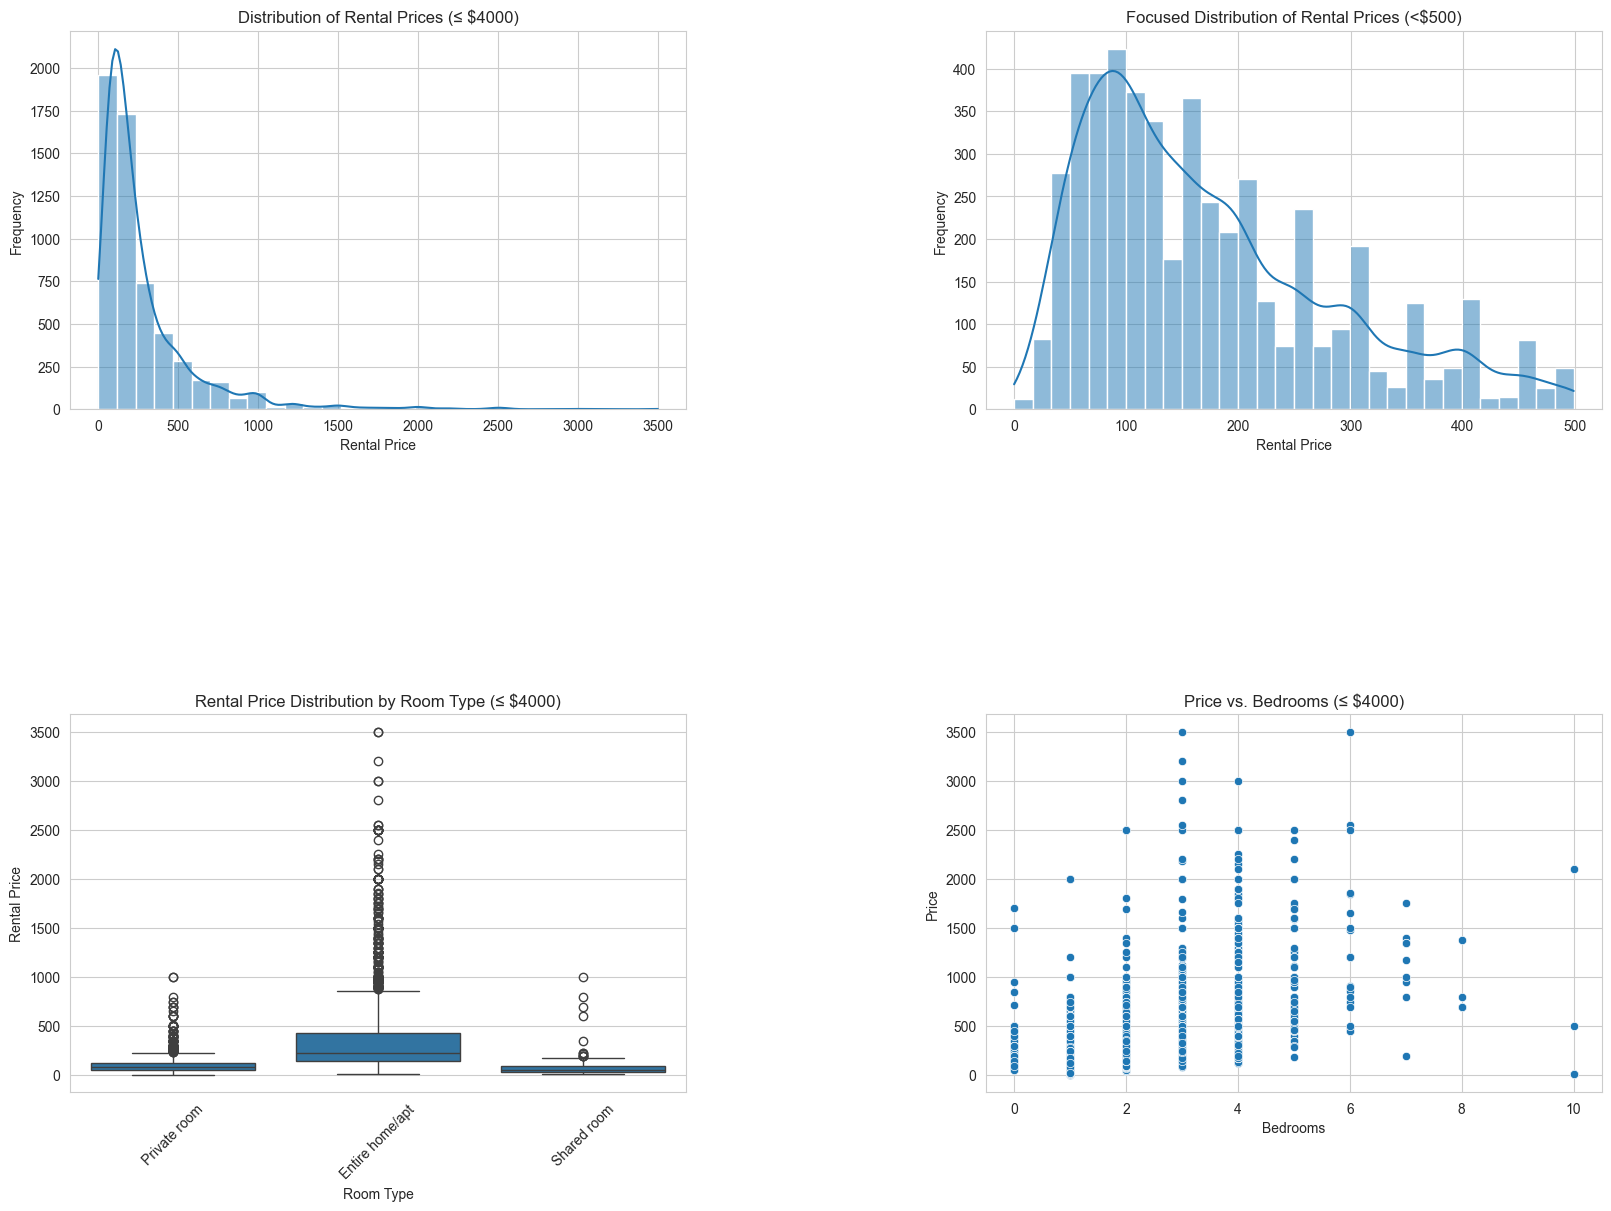

Note: Rental prices above $4000 have been excluded from the visualizations to allow for better display.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

merged_df = pd.concat([rating_features_data, rental_price_data['price']], axis=1)

# Ensure 'price' is converted to numeric (float)
merged_df['price'] = pd.to_numeric(merged_df['price'].replace('[\$,]', '', regex=True), errors='coerce')

# Drop any rows where 'price' could not be converted and ended up as NaN
merged_df = merged_df.dropna(subset=['price'])

# Set up the figure for a 2x2 grid of plots with increased spacing and use constrained layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'hspace': 0.4, 'wspace': 0.3}, constrained_layout=True)

# Histogram of Rental Prices (excluding prices above $4000)
filtered_prices = merged_df[merged_df['price'] <= 4000]['price']
sns.histplot(filtered_prices, bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Rental Prices (≤ $4000)')
axes[0, 0].set_xlabel('Rental Price')
axes[0, 0].set_ylabel('Frequency')

# Focused Histogram of Rental Prices in a Main Area (e.g., prices below a threshold)
sns.histplot(merged_df[merged_df['price'] < 500]['price'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Focused Distribution of Rental Prices (<$500)')
axes[0, 1].set_xlabel('Rental Price')
axes[0, 1].set_ylabel('Frequency')

# Boxplot of Prices by Room Type (excluding prices above $4000)
sns.boxplot(x='room_type', y='price', data=merged_df[merged_df['price'] <= 4000], ax=axes[1, 0])
axes[1, 0].set_title('Rental Price Distribution by Room Type (≤ $4000)')
axes[1, 0].set_xlabel('Room Type')
axes[1, 0].set_ylabel('Rental Price')
axes[1, 0].tick_params(axis='x', rotation=45)

# Scatter Plot of Price vs. Bedrooms (excluding prices above $4000)
sns.scatterplot(x='bedrooms', y='price', data=merged_df[merged_df['price'] <= 4000], ax=axes[1, 1])
axes[1, 1].set_title('Price vs. Bedrooms (≤ $4000)')
axes[1, 1].set_xlabel('Bedrooms')
axes[1, 1].set_ylabel('Price')

# Adjust layout
plt.show()

# Note about excluded prices
print("Note: Rental prices above $4000 have been excluded from the visualizations to allow for better display.")

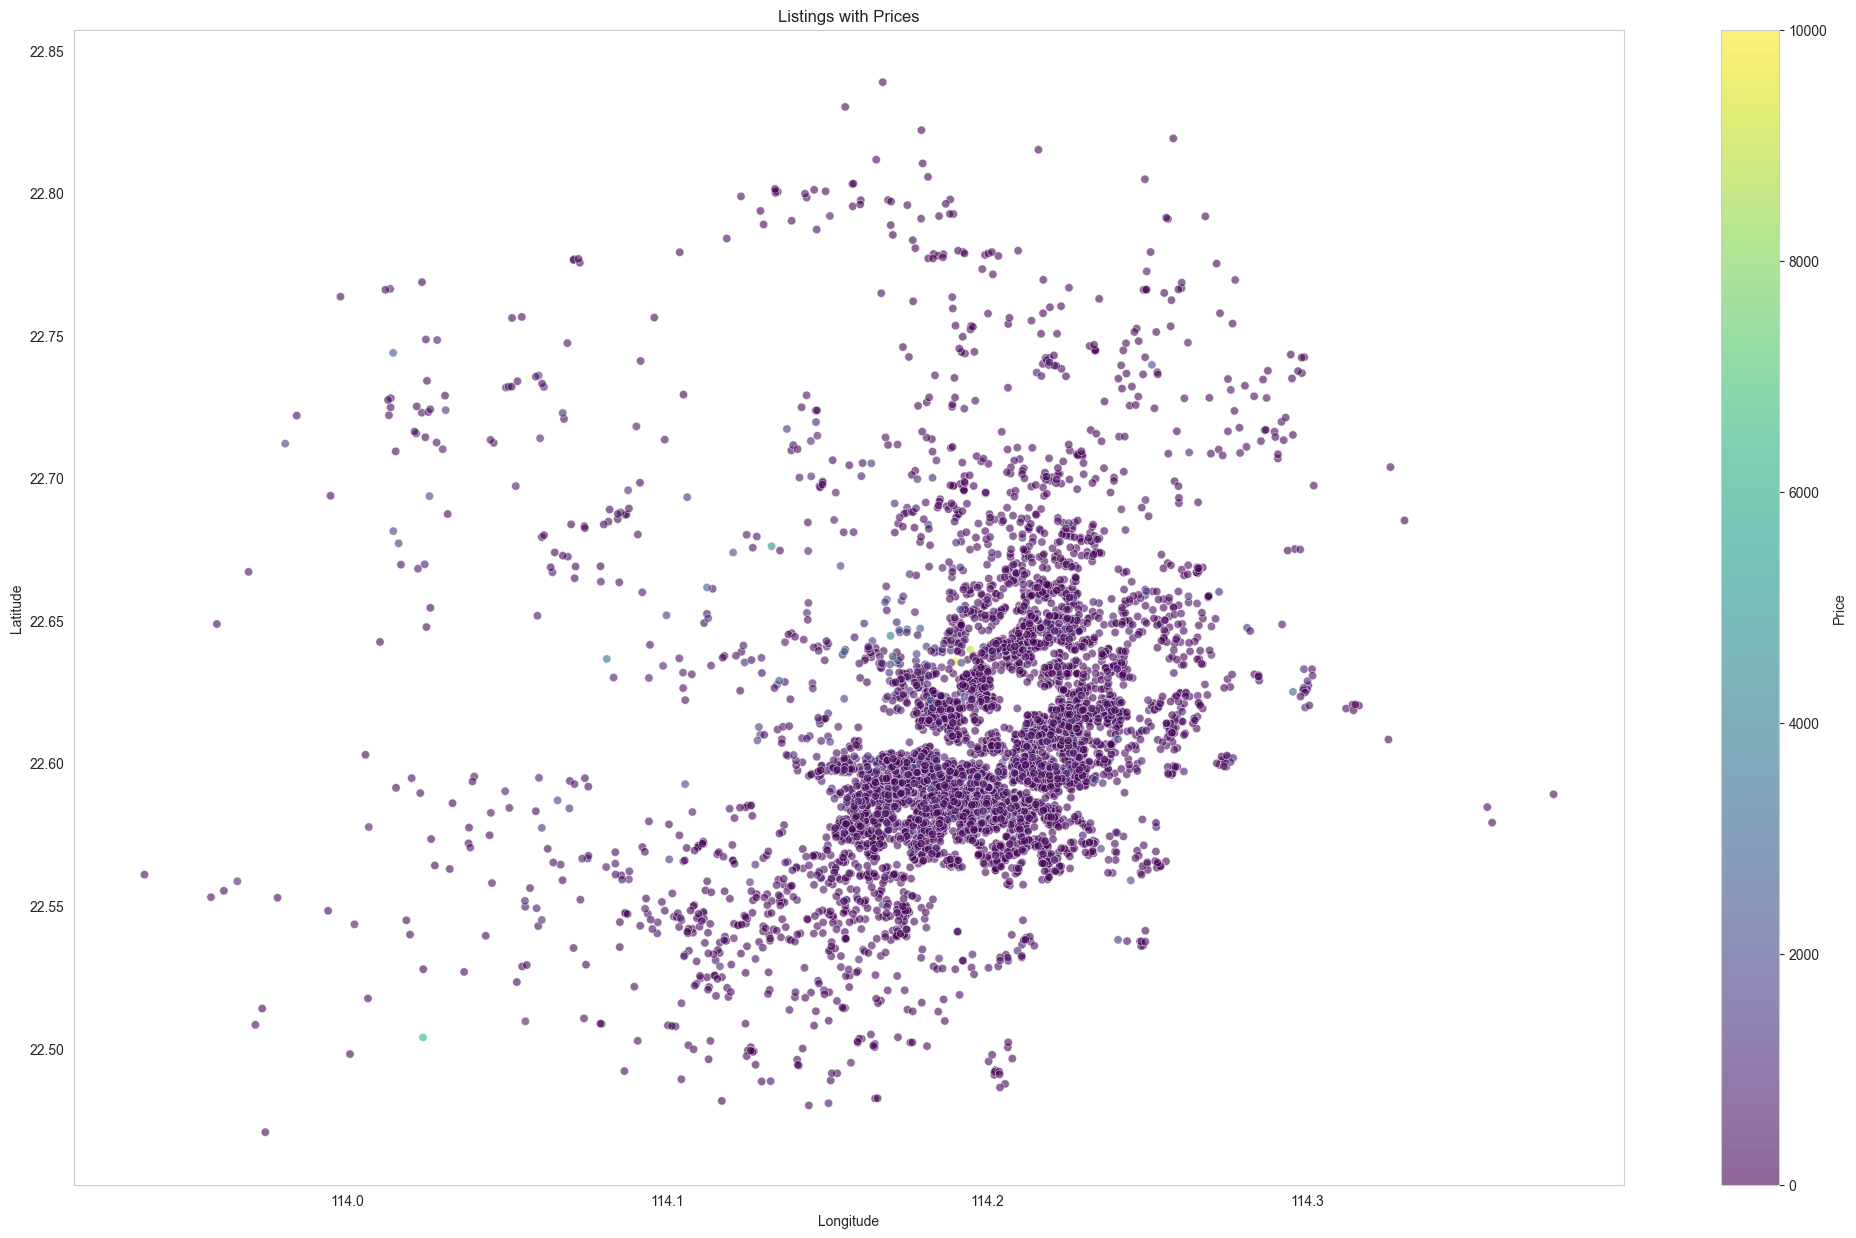

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Create a plot
fig, ax = plt.subplots(figsize=(25, 15))


# Plot the data points with color corresponding to the price
sc = ax.scatter(merged_df['longitude(East)'], merged_df['latitude(North)'],
                c=merged_df['price'], cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5, zorder=1)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Price')

# Set plot title and labels
ax.set_title('Listings with Prices')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove gridlines
ax.grid(False)

# Show the plot
plt.show()

# Preprocessing

- we only look at key ameniteis based on their frequency in the data set and perosonal obsrvation on most important amenities.

### Missing Values
- for missing values bathrooms, beds, review_scores_checkin, review_scores_communication, review_scores_location,
review_scores_rating, review_scores_value mean was assesed. 
- for is host_is_superhost flase is assumed
- for host_listings_count 1 is assuemed. Therefor it is assumed that the host only has one listing.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Load the datasets
rental_price_data = pd.read_csv('../data/rental_price.csv')
rating_features_data = pd.read_csv('../data/rating_features.csv')

# Function to extract key amenities directly from the amenities string
def extract_key_amenities_directly(amenities):
    key_amenities = ['Internet', 'Wireless Internet', 'Kitchen', 'Heating', 'Essentials', 'TV',
                     'Washer', 'Dryer', 'Free parking on premises', 'Air conditioning', 'Breakfast',
                     'Pets allowed', 'Family/kid friendly', 'Suitable for events']
    # Normalize the amenities string for consistent matching
    amenities = amenities.lower().replace('"', '').replace('{', '').replace('}', '').replace(' ', '')
    features = {amenity: 1 if amenity.lower().replace(' ', '') in amenities else 0 for amenity in key_amenities}
    return pd.Series(features)

# Apply the function to extract key amenities and add them as new columns
key_amenities_df = rating_features_data['amenities'].apply(extract_key_amenities_directly)
rating_features_data = pd.concat([rating_features_data, key_amenities_df], axis=1)

# Optionally drop the original 'amenities' column if no longer needed
rating_features_data.drop('amenities', axis=1, inplace=True)

# Convert price from string to float
rental_price_data['price'] = rental_price_data['price'].replace('[\$,]', '', regex=True).astype(float)

# Check for missing values
print("Before Preproccessing")
print("Missing values in rental data:", rental_price_data.isnull().sum())
print("Missing values in rating features data:", rating_features_data.isnull().sum())

# Fill missing values in 'host_is_superhost' with False
rating_features_data['host_is_superhost'].fillna('f', inplace=True)

# Fill missing values in 'host_listings_count' with 1
rating_features_data['host_listings_count'].fillna(1, inplace=True)


# Fill missing values for numerical columns with the median
for column in rating_features_data.select_dtypes(include=['float64', 'int64']).columns:
    median_value = rating_features_data[column].median()
    rating_features_data[column].fillna(median_value, inplace=True)
    
#Scale Nummerical Values with MinMaxScaler
scaler = MinMaxScaler()
numerical_columns = rating_features_data.select_dtypes(include=['float64', 'int64']).columns
rating_features_data[numerical_columns] = scaler.fit_transform(rating_features_data[numerical_columns])

# Has availabiltiy is allways true. Therefor it can be droped
rating_features_data.drop('has_availability',axis=1, inplace=True)

#Replace t and f with True and False
mapping = {'f': 0, 't': 1}
rating_features_data['host_is_superhost'] = rating_features_data['host_is_superhost'].map(mapping)
rating_features_data['instant_bookable'] = rating_features_data['instant_bookable'].map(mapping)

# Encode categorical variables using one-hot encoding
categorical_columns = ['room_type', 'bed_type', 'property_type', 'cancellation_policy']
rating_features_data = pd.get_dummies(rating_features_data, columns=categorical_columns)

#Convert all Data to numerical data
rating_features_data = rating_features_data.astype(float)

pd.set_option('display.max_columns', None)

# Convert to DataFrame and use to_string to display all columns
rental_missing = rental_price_data.isnull().sum().reset_index()
rating_missing = rating_features_data.isnull().sum().reset_index()

# Print to check if there are still missing values
print("\nMissing values in rental data:\n", rental_missing.to_string(index=False, header=['Column', 'Missing Values']))
print("Missing values in rating features data:\n", rating_missing.to_string(index=False, header=['Column', 'Missing Values']))


Before Preproccessing
Missing values in rental data: price    0
dtype: int64
Missing values in rating features data: accommodates                         0
availability_30                      0
bathrooms                           46
bed_type                             0
bedrooms                             6
beds                                23
calculated_host_listings_count       0
cancellation_policy                  0
guests_included                      0
has_availability                     0
host_is_superhost                   15
host_listings_count                 15
instant_bookable                     0
latitude(North)                      0
longitude(East)                      0
maximum_nights                       0
number_of_reviews                    0
property_type                        0
review_scores_checkin             2057
review_scores_communication       2057
review_scores_location            2056
review_scores_rating              2046
review_scores_value      

In [5]:
import pandas as pd

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers

# Detect outliers in 'price'
price_outliers = detect_outliers_iqr(rental_price_data, 'price')
print("\nOutliers detected based on price:\n", price_outliers.sum())

#Outlier Removal
rental_price_data = rental_price_data[~price_outliers]
rating_features_data = rating_features_data.loc[rental_price_data.index]

# Print the datasets after removing outliers
print("\nData after outlier removal based on price:")
print(rental_price_data.describe())
print(rating_features_data.describe())


Outliers detected based on price:
 392

Data after outlier removal based on price:
             price
count  5442.000000
mean    211.327821
std     164.683574
min       0.000000
25%      90.000000
50%     150.000000
75%     288.000000
max     785.000000
       accommodates  availability_30    bathrooms     bedrooms         beds  \
count   5442.000000      5442.000000  5442.000000  5442.000000  5442.000000   
mean       0.208355         0.546650     0.172627     0.160842     0.069815   
std        0.163650         0.407600     0.078853     0.099720     0.095001   
min        0.000000         0.000000     0.000000     0.000000     0.000000   
25%        0.066667         0.033333     0.125000     0.100000     0.000000   
50%        0.200000         0.633333     0.125000     0.100000     0.066667   
75%        0.333333         0.966667     0.250000     0.200000     0.133333   
max        1.000000         1.000000     1.000000     1.000000     1.000000   

       calculated_host_listings_c

## Merge Data Sets and Definition of X and Y. 
## Train Test split to ensure there is no data leakage.

This will be used in the rest of the code

In [6]:
from sklearn.model_selection import train_test_split
# Merge the datasets based on a common key
merged_df = pd.concat([rating_features_data, rental_price_data], axis=1)

# Analyze variance explained by each feature
X = merged_df.drop(columns='price')  # Drop rental price
y = merged_df['price']

# Train Test split with stratification
# y_binned = pd.qcut(y, q=10, labels=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #stratify=y_binned

new map

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots(figsize=(25, 15))


# Plot the data points with color corresponding to the price
sc = ax.scatter(merged_df['longitude(East)'], merged_df['latitude(North)'],
                c=merged_df['price'], cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5, zorder=1)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Price')

# Set plot title and labels
ax.set_title('Listings with Prices')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove gridlines
ax.grid(False)

# Show the plot
plt.show()

KeyboardInterrupt: 

# Correlation Analysis

- Analysis what coloumns have an high impact on rent price.
- Variance Explination Calculation
- Correlation Matrix between the rating features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation
correlation_matrix = merged_df.corr()
rental_price_correlation = correlation_matrix['price'].sort_values(ascending=False)
pd.set_option('display.max_columns', None)
print("Correlation with rental price:")
print(rental_price_correlation)

# Filter features based on correlation threshold
filtered_rental_price_correlation = rental_price_correlation.drop('price')[(rental_price_correlation.drop('price') > 0.2) | (rental_price_correlation.drop('price') < -0.2)]

plt.figure(figsize=(10, 8))
filtered_rental_price_correlation.plot(kind='bar', color='red', alpha=0.5)  # Added red color and transparency
plt.title('Correlation with Rental Price (Filtered)')
plt.xlabel('Features')
plt.ylabel('Correlation coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Model Selection

Deciding what models are the most promising to optimize 


In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Elastic Net': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=25),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'AdaBoost Regressor': AdaBoostRegressor(random_state=42),
    'Extra Trees Regressor': ExtraTreesRegressor(random_state=42),
    'Neural Network Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse=np.sqrt(mse)
    results[name] = {'MSE': mse, 'R^2': r2, 'RSME': rmse }
    print(f"\n{name}: \n Mean Squared Error: {mse}\n Root Mean Squared Error: {rmse},\n R^2 Score: {r2}\n")


The best Models are:

1. Gradient Booster Regressor
2. Random Forest 

## Hyperparmeter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grids
param_grid_gbr = {
    'n_estimators': [ 100,200,300],
    'learning_rate': [0.01, 0.025, 0.05],
    'max_depth': [2,3,4],
    'min_samples_split':[5,10,15]}

param_grid_rf = {
    'n_estimators': [ 300, 400, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [ 5, 10, 15]}

# Initialize the models
gbr = GradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV for each model
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)

# Fit the models
grid_search_gbr.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

# Best parameters and scores
best_gbr = grid_search_gbr.best_estimator_
best_rf = grid_search_rf.best_estimator_

# Predict and evaluate
models = {
    'Gradient Boosting Regressor': best_gbr,
    'Random Forest Regressor': best_rf,
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = {'MSE': mse, 'R^2': r2, 'RMSE': rmse}
    print(f"{name} - Mean Squared Error: {mse}, R^2 Score: {r2}, Root Mean Squared Error: {rmse}")

# Print best parameters
print("Best parameters for Gradient Boosting Regressor: ", grid_search_gbr.best_params_)
print("Best parameters for Random Forest Regressor: ", grid_search_rf.best_params_)


## Feature Importance

## Model optimisation with important Features

## Model Evaluation

1. The best Model is the Gradient Boosting Regressor Model with all Features.  
It achieves the following results:  
   - R²: 0.6231,
   - MSE: 10944.5661,
   - RMSE: 104.6163
2. The Gradient Boosting Regressor Model with a threshold of 0.01 almost has the same performance but can also be used if data collection is expensive or performance if of critical importance
3. The Radom Forest with a feature threshold of 0.05 however is the model we continued with, as first further results lead to some overfitting concerns for the Gradient Boosting Regressor.  
It achieves the following results:  
    - R²: 0.5867,
    - MSE: 10977.7669,
    - RMSE: 104.7748


## Model Visualisation
For the following, we visualized a GBR Tree as well as an example tree from the random forest. (For both only 4 depth)

In [ ]:
from sklearn.tree import plot_tree

best_gbr.fit(X_train, y_train)

# Access the first tree in the first stage of boosting
estimator = best_gbr.estimators_[0, 0]  # [0, 0] for the first stage of boosting and the first tree in that stage

# Plot the tree using plot_tree
plt.figure(figsize=(20,15))
plot_tree(estimator, filled=True, feature_names=X_train.columns, rounded=True, max_depth=4)
plt.title("Tree from Gradient Boosting Regressor")
plt.show()


## Undervalued Hotels
As a key finding, we looked at Hotels who are priced lower than the estimation. These Hotels may be subject to missed potential and due for a price adjustment. 

In [ ]:
# Access the best model and features for the Random Forest from previous results
# best_rf_model = models.get('Random Forest') #best_details['Random Forest Regressor']['best_model']
# best_features_indices = best_details['Random Forest Regressor']['best_features_indices']
# best_features = X.columns[best_features_indices]

# Fit the best RF model on the entire dataset using the selected features
best_gbr.fit(X, y)
predicted_prices = best_gbr.predict(X)

# Add predicted prices to the data
merged_df['predicted_price'] = predicted_prices

# Calculate the difference between actual and predicted prices
merged_df['price_difference'] = merged_df['price'] - merged_df['predicted_price']

# Calculate the percentage difference
merged_df['percentage_difference'] = (merged_df['price_difference'] / merged_df['predicted_price']) * 100

# Identify significantly undervalued hotels
significant_threshold = -33  # Negative because the actual price is lower than predicted
significantly_undervalued_hotels = merged_df[merged_df['percentage_difference'] < significant_threshold]

# Display the total count of significantly undervalued hotels
total_undervalued_hotels = len(significantly_undervalued_hotels)
print(f"Total number of significantly undervalued hotels: {total_undervalued_hotels}")

# Assuming 'numerical_columns' and 'scaler' are defined, apply inverse transform to scale back the data
significantly_undervalued_hotels[numerical_columns] = scaler.inverse_transform(significantly_undervalued_hotels[numerical_columns])

# Display the significantly undervalued hotels
print(significantly_undervalued_hotels[['price', 'predicted_price', 'price_difference', 'percentage_difference']])


## Map
For visualization only, we plotted all undervalued Hotels on a map. Please note that this is for Visualiziation only and NOT TO SCALE. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots(figsize=(25, 15))


# Plot the data points with color corresponding to the price
sc = ax.scatter(significantly_undervalued_hotels['longitude(East)'], significantly_undervalued_hotels['latitude(North)'],
                c=significantly_undervalued_hotels['price'], cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5, zorder=1)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label('Price')

# Set plot title and labels
ax.set_title('Undervalued Hotels')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove gridlines
ax.grid(False)

# Show the plot
plt.show()
significantly_undervalued_hotels

## Insights for undervalued Hotels
Especially for the undervalued Hotels, we looked at differences to all Hotels 

In [ ]:
from scipy.stats import ttest_ind, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Add a column to distinguish between undervalued and all hotels
merged_df['category'] = 'All Hotels'
significantly_undervalued_hotels['category'] = 'Undervalued Hotels'

# Combine the dataframes
comparison_df = pd.concat([merged_df, significantly_undervalued_hotels])

# Function to perform t-test for continuous variables and chi-square test for categorical variables
def test_significance(df, feature, categorical=False):
    group1 = df[df['category'] == 'All Hotels'][feature]
    group2 = df[df['category'] == 'Undervalued Hotels'][feature]
    if categorical:
        contingency_table = pd.crosstab(df['category'], df[feature])
        _, p_value, _, _ = chi2_contingency(contingency_table)
    else:
        _, p_value = ttest_ind(group1, group2, nan_policy='omit')
    return p_value

# List of features to test
features_to_test = [
    'review_scores_rating', 'number_of_reviews', 'bathrooms', 'availability_30',
    'accommodates', 'host_listings_count', 'bedrooms', 'beds',
    'maximum_nights', 'guests_included', 'room_type_Entire home/apt', 'room_type_Private room',
    'Essentials', 'Kitchen', 'Washer', 'Dryer',
    'Heating', 'Internet', 'Wireless Internet', 'Air conditioning'
]

# Determine significant features
significant_features = []
alpha = 0.05  # significance level

for feature in features_to_test:
    categorical = 'room_type' in feature or feature in ['Essentials', 'Kitchen', 'Washer', 'Dryer', 'Heating', 'Internet', 'Wireless Internet', 'Air conditioning']
    p_value = test_significance(comparison_df, feature, categorical=categorical)
    if p_value < alpha:
        significant_features.append(feature)

print(f"Significant features: {significant_features[:10]}")

# Calculate mean percentage differences
mean_percentage_diffs = []
for feature in significant_features[:10]:
    mean_all = comparison_df[comparison_df['category'] == 'All Hotels'][feature].mean()
    mean_undervalued = comparison_df[comparison_df['category'] == 'Undervalued Hotels'][feature].mean()
    mean_diff = (mean_undervalued - mean_all) / mean_all * 100
    mean_percentage_diffs.append(mean_diff)

# Create a bar plot for mean percentage differences
plt.figure(figsize=(14, 8))
sns.barplot(x=significant_features[:10], y=mean_percentage_diffs, color='red', alpha=0.5)
plt.title('Mean Percentage Differences of Significant Features Between Undervalued and All Hotels')
plt.xlabel('Features')
plt.ylabel('Mean Percentage Difference (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# best_details['Random Forest Regressor']['best_model']
models.get('Random Forest')